# **ARIMA**

In [1]:
!git clone https://github.com/Astralex98/MOSD_2023.git

fatal: destination path 'MOSD_2023' already exists and is not an empty directory.


In [2]:
%cd MOSD_2023/Seminar_3

/content/MOSD_2023/Seminar_3


In [3]:
!pwd

/content/MOSD_2023/Seminar_3


## Dependencies

In [4]:
!unzip data.zip -d .

Archive:  data.zip
replace ./data/mauna_loa_atmospheric_c02.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ./data/mauna_loa_atmospheric_c02.csv  
  inflating: ./figures/in-sample.png  
  inflating: ./figures/ts-k-fold.png  


In [5]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import statsmodels as sm
import statsmodels.api

from tqdm import tqdm

In [6]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

#### А. Downloading data

In [7]:
dataset = pd.read_csv("./data/mauna_loa_atmospheric_c02.csv",
                      index_col=None, usecols=["date", "WMLCO2"])

In [8]:
dataset.head()

,date,WMLCO2
0,1958-03-29,316.1
1,1958-04-05,317.3
2,1958-04-12,317.6
3,1958-04-19,317.5
4,1958-04-26,316.4


When loading a time series in Pandas, you must explicitly indicate the need
converting date-time stamps from text to date-time format.

* This can also be specified when calling `pd.read_csv`

In [9]:
dataset["date"] = pd.to_datetime(dataset["date"], format="%Y-%m-%d")

Rename columns

In [10]:
dataset = dataset.rename(columns={"date": "data", "WMLCO2": "concentration CO2"})

In [11]:
dataset.head()

,data,concentration CO2
0,1958-03-29,316.1
1,1958-04-05,317.3
2,1958-04-12,317.6
3,1958-04-19,317.5
4,1958-04-26,316.4


In [12]:
dataset = dataset.set_index("data").to_period("W")
dataset = dataset.to_timestamp()
dataset = dataset.resample("M").mean()

In [13]:
dataset.head()

,concentration CO2
data,
1958-03-31,316.700
1958-04-30,317.100
1958-05-31,317.700
1958-06-30,315.800
1958-07-31,315.575


#### В. Filling missing values

In [14]:
maginfy_slice = slice("1960", "1967")

In [15]:
dataset_pinterp = dataset.interpolate(method='polynomial', order=2)
full_dataset = dataset_pinterp

 ### C. Preparation of test and train samples

In [16]:
dataset_pinterp = dataset.interpolate(method='polynomial', order=2)
full_dataset = dataset_pinterp

In [17]:
holdout = full_dataset.loc["1991-01-01":]

dataset = full_dataset.loc[:"1990-12-31"]

print(len(dataset), len(holdout))

394 132


Make sure the parts don't overlap

In [18]:
pd.concat([
    dataset.tail(),
    holdout.head()
], axis=1)

,concentration CO2,concentration CO2
data,,
1990-08-31,352.250,NaN
1990-09-30,350.950,NaN
1990-10-31,351.400,NaN
1990-11-30,353.075,NaN
1990-12-31,354.260,NaN
1991-01-31,NaN,354.925
1991-02-28,NaN,355.950
1991-03-31,NaN,357.400
1991-04-30,NaN,358.700


Explicitly preserve the boundaries of the segments

In [19]:
holdout_slice = slice(*holdout.index[[0, -1]])

print("Train sample from {} to {}".format(*dataset.index[[0, -1]]))

print("Test sample from {} to {}".format(holdout_slice.start, holdout_slice.stop))

Train sample from 1958-03-31 00:00:00 to 1990-12-31 00:00:00
Test sample from 1991-01-31 00:00:00 to 2001-12-31 00:00:00


Choose a column

In [20]:
target_column = "concentration CO2"

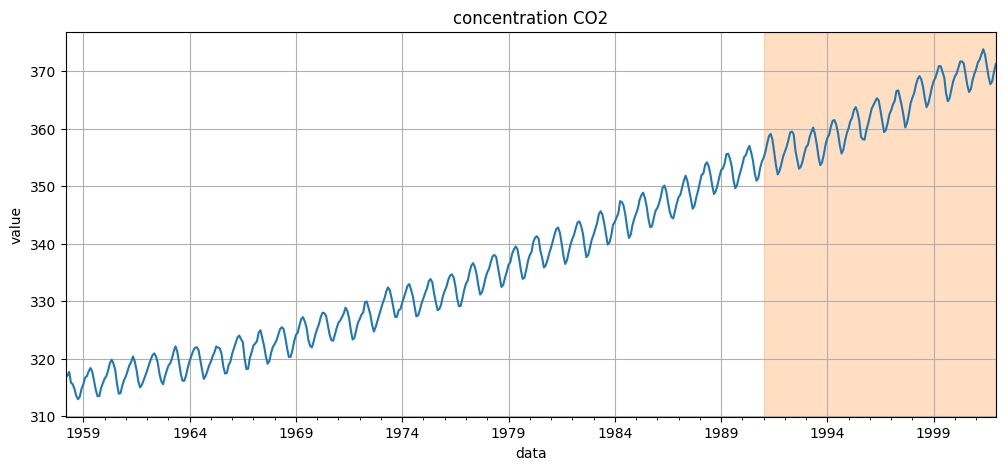

In [21]:
# create and set plot
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Data", ylabel="value", title=target_column)

# plote dynamic of the whole series
full_dataset[target_column].plot(ax=ax)

# darkening delayed interval
ax.axvspan(holdout_slice.start, holdout_slice.stop,
           color="C1", alpha=0.25, zorder=-99)

ax.grid(which="major", axis="both") ;


<br>

###   А. Moving characteristics

Below is a procedure for conveniently plotting diagnostic graphs.

In [22]:
def rolling_diagnostics(series, window=500):
    rolling = series.rolling(window)

    # Create and set plots: upper and down
    fig = plt.figure(figsize=(12, 6))
    ax_top = fig.add_subplot(211, title="Moving average", xlabel="Data", ylabel="value")
    ax_bottom = fig.add_subplot(212, title="Moving stdv",
                                sharex=ax_top, xlabel="Data", ylabel="stdv")

    # plot graphs:
    # serries and moving average


    rolling_mean = rolling.mean()
    rolling_mean.plot(ax=ax_top)
    series.plot(ax=ax_top, color="black", lw=2, alpha=.25, zorder=-10)
    ax_top.grid(which="major", axis="both")

    # moving standard deviation
    rolling_std = rolling.std()
    rolling_std.plot(ax=ax_bottom)
    ax_bottom.grid(which="major", axis="both")

    fig.tight_layout()
    return fig

From the graphs of moving statistics, we can suggest that there is a trend in the dynamics of values.

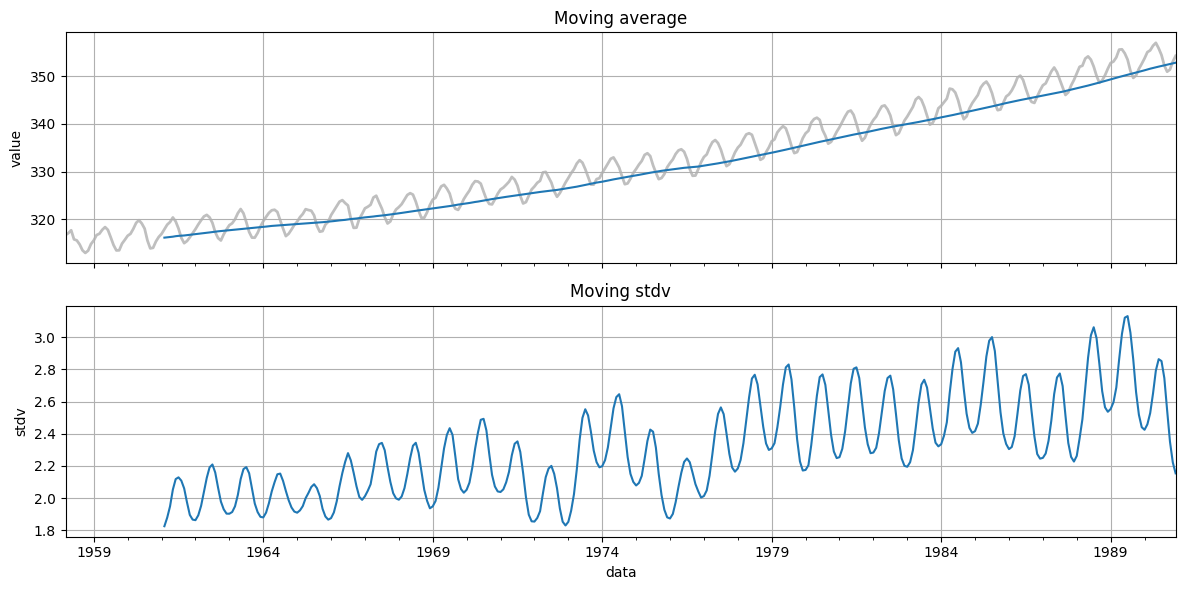

In [23]:
rolling_diagnostics(dataset[target_column], window=36);

<br>

### Rough estimate of seasonality

You can try researching seasonality, such as monthly or weekly.

* when assessing seasonality, it is desirable that seasonal adjustments are made relative to the trend.

In [24]:
def monthly_seasonality_diagnostics(series, fraction=0.66, period="month"):
    # use nonparametric local linear regression to estimate the trend
    trend = sm.api.nonparametric.lowess(series, np.r_[:len(series)],
                                        frac=fraction, it=5)

    # let's group by month and calculate the average and std. deviation
    by = getattr(series.index, period, "month")
    season_groupby = (series - trend[:, 1]).groupby(by)
    seas_mean, seas_std = season_groupby.mean(), season_groupby.std()

    # create and plot graphs: upper and down
    fig = plt.figure(figsize=(12, 6))
    ax_top = fig.add_subplot(211, title="Trend", xlabel="Data")
    ax_bottom = fig.add_subplot(212, title="Seasonality", xlabel=period)

    # plot graphs
    # series and trend
    pd.Series(trend[:, 1], index=series.index).plot(ax=ax_top)
    series.plot(ax=ax_top, color="black", lw=2, alpha=.25, zorder=-10)
    ax_top.grid(which="major", axis="both")

    # seasonality and 90% confidence interval
    ax_bottom.plot(1 + np.r_[:len(seas_mean)], seas_mean, lw=2)
    ax_bottom.fill_between(1 + np.r_[:len(seas_mean)],
                           seas_mean - 1.96 * seas_std,
                           seas_mean + 1.96 * seas_std,
                           zorder=-10, color="C1", alpha=0.15)
    ax_bottom.grid(which="major", axis="both")


    fig.tight_layout()
    return fig

Plots shows seasonality in dynamics

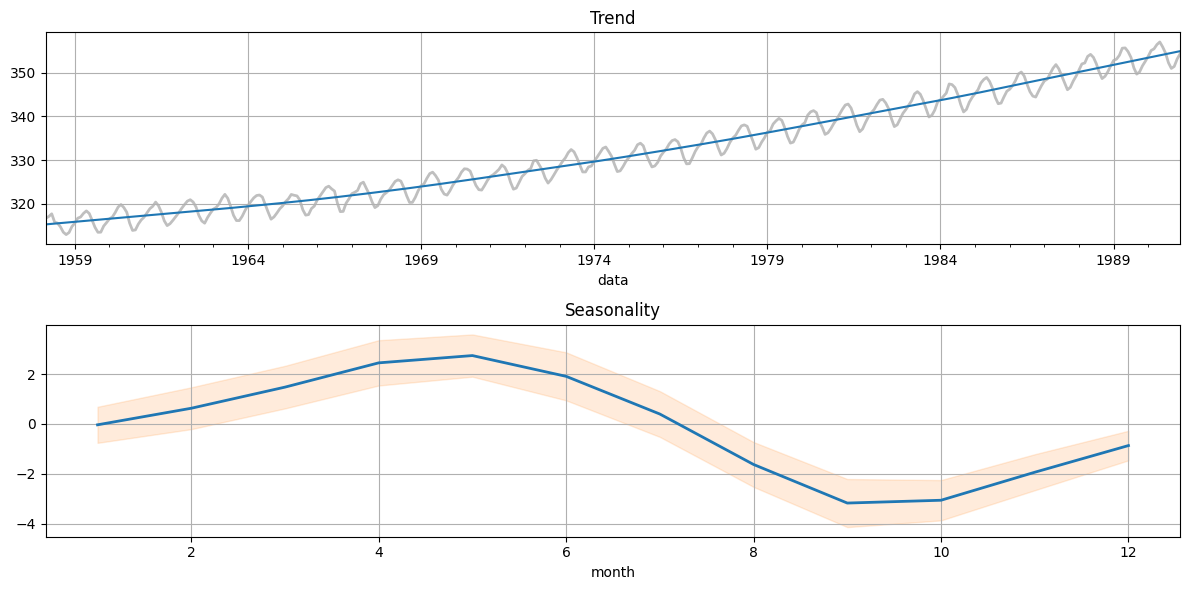

In [25]:
monthly_seasonality_diagnostics(dataset[target_column], fraction=0.33, period="month");

<br>

In [26]:
from statsmodels.tsa.stattools import acf, pacf

Below is a procedure for conveniently plotting diagnostic graphs.

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def correlation_diagnostics(series, lags=60):
    # create and set plots: left and right
    fig = plt.figure(figsize=(12, 3))
    ax_left, ax_right = fig.subplots(
        nrows=1, ncols=2, sharey=True, sharex=True,
        subplot_kw={"xlabel": "Lag", "ylim": (-1.1, 1.1)})

    # Plot graphs using built-in functions from statsmodels
    plot_acf(series, ax_left, lags=lags, zero=False, alpha=0.05,
             title="Sample Autocorrelation", marker=None)

    plot_pacf(series, ax_right, lags=lags, zero=False, alpha=0.05,
              title="Sample Partial Autocorrelation", marker=None)

    fig.tight_layout()
    return fig

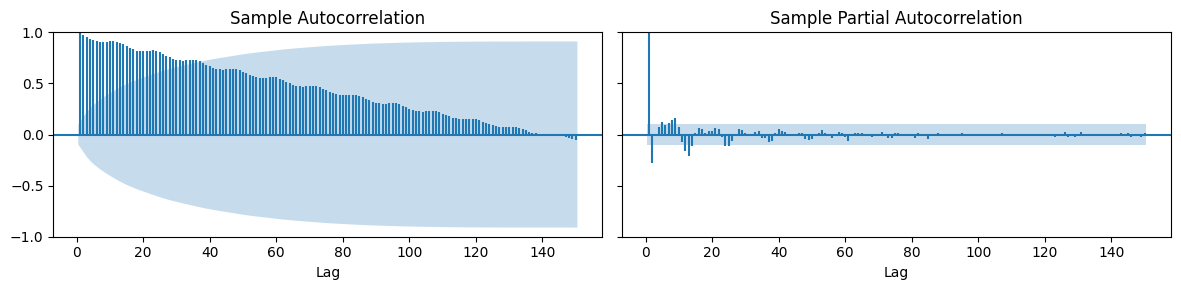

In [28]:
correlation_diagnostics(dataset[target_column], lags=150);

All diagnostics in one procedure:

In [29]:
def diagnostics(series, window=250, fraction=0.25, lags=150):
    # moving statistics
    rolling_diagnostics(series, window=window)
    plt.show()
    plt.close()

    # rough seasonality
    monthly_seasonality_diagnostics(series, fraction=fraction)
    plt.show()
    plt.close()

    # autocorrelation
    correlation_diagnostics(series, lags=lags)
    plt.show()
    plt.close()

    return stat_test_diagnostics(series)

In [30]:
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

# A procedure that returns test statistics and the corresponding  p - value
def stat_test_diagnostics(series):
    return {
        "ADF": adfuller(series, regression="ct")[:2],
        "KPSS": kpss(series, regression="c")[:2],
    }

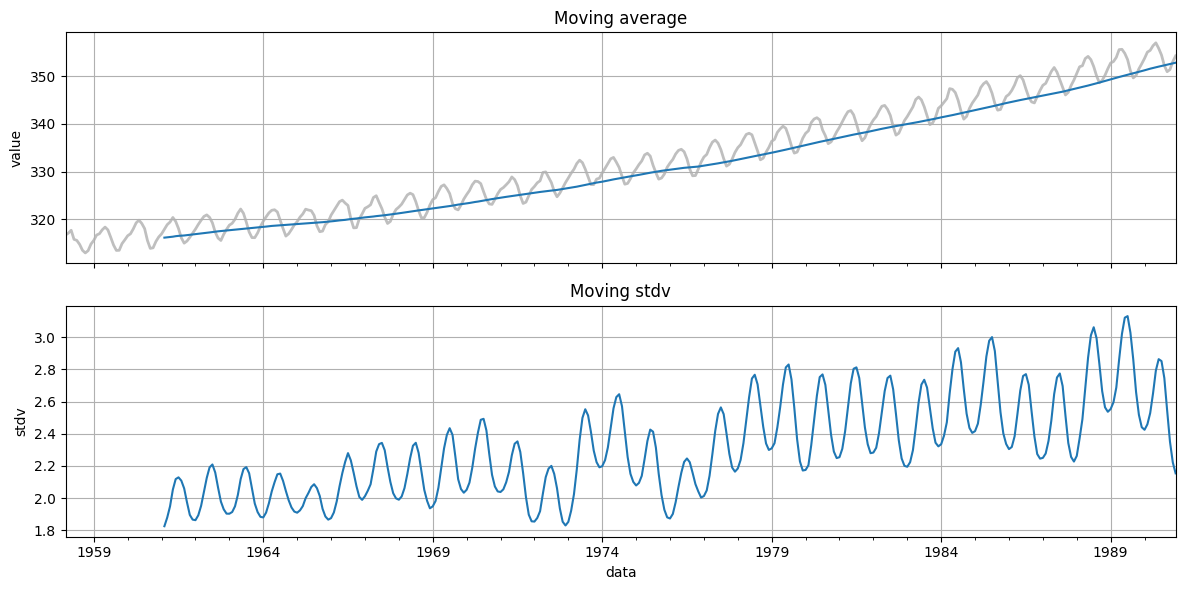

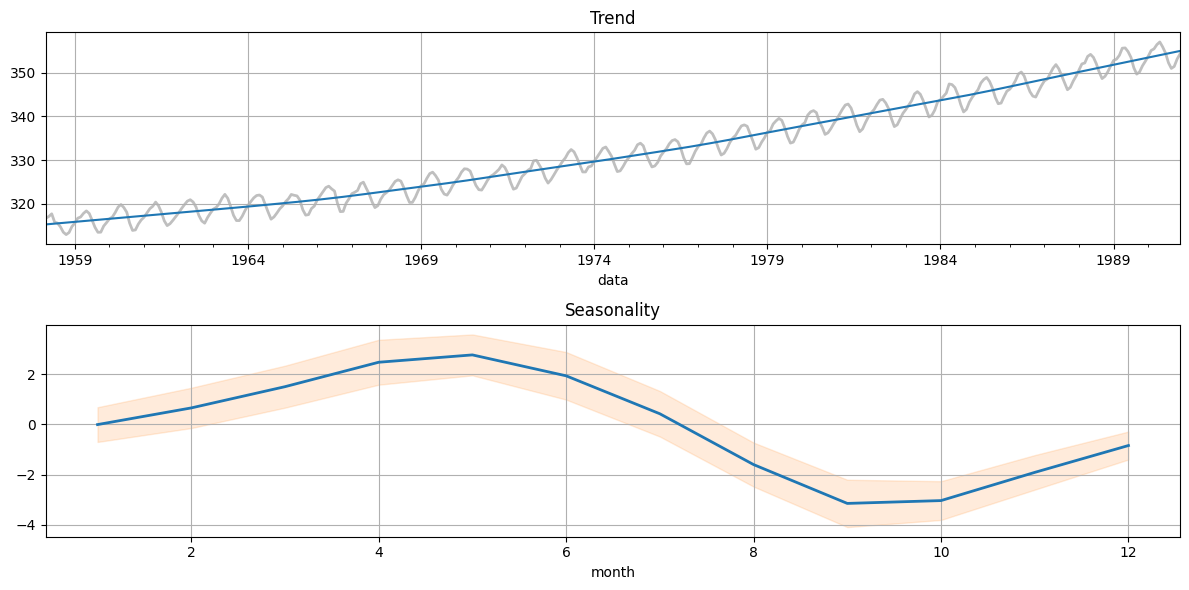

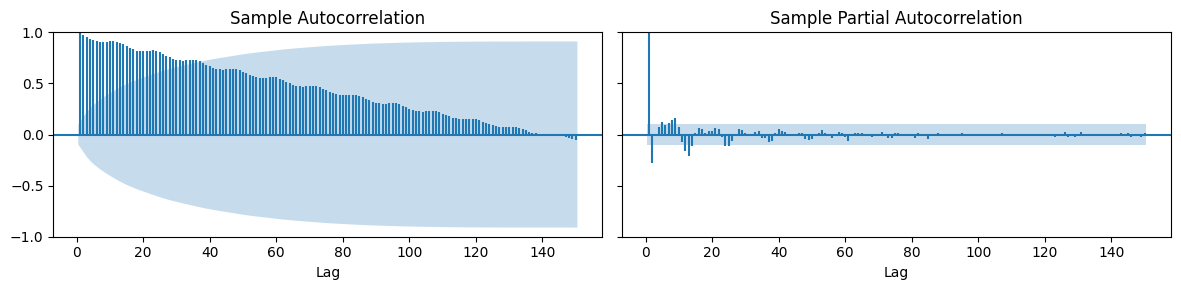

<ipython-input-30-afc5a90b209f>:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  "KPSS": kpss(series, regression="c")[:2],


{'ADF': (-1.5871756923514098, 0.7974141230613575),
 'KPSS': (3.336296447917031, 0.01)}

In [31]:
diagnostics(dataset[target_column], window=36)

####  А. Bringing data to a stationary form

In [32]:
from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import StandardScaler

Our seria is positive, so we can take logs

In [33]:
#TODO: apply other transformations to the data and try to find the best for making Time Series stationary

from sklearn.pipeline import Pipeline

transformer = Pipeline([
    ("Log", FunctionTransformer(func=np.log, inverse_func=np.exp),),

    ("Scaling", StandardScaler(),),
])

Transformation

In [34]:
log_dataset = pd.DataFrame(transformer.fit_transform(dataset),
                           columns=dataset.columns,
                           index=dataset.index)

In [35]:
log_dataset.head()

,concentration CO2
data,
1958-03-31,-1.296455
1958-04-30,-1.261055
1958-05-31,-1.208038
1958-06-30,-1.376270
1958-07-31,-1.396259


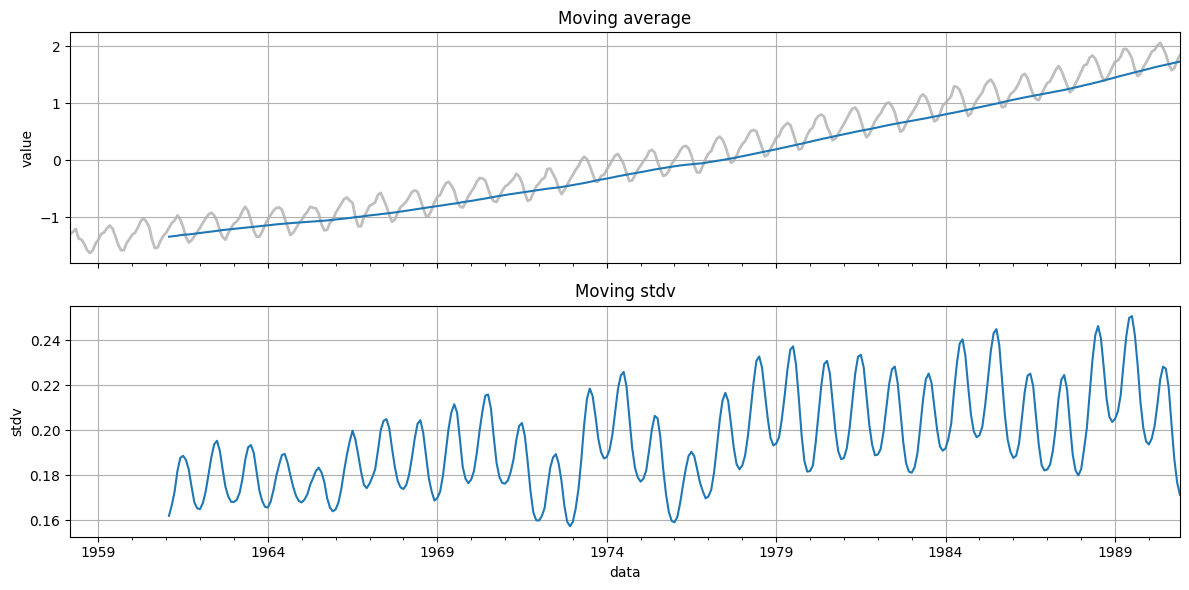

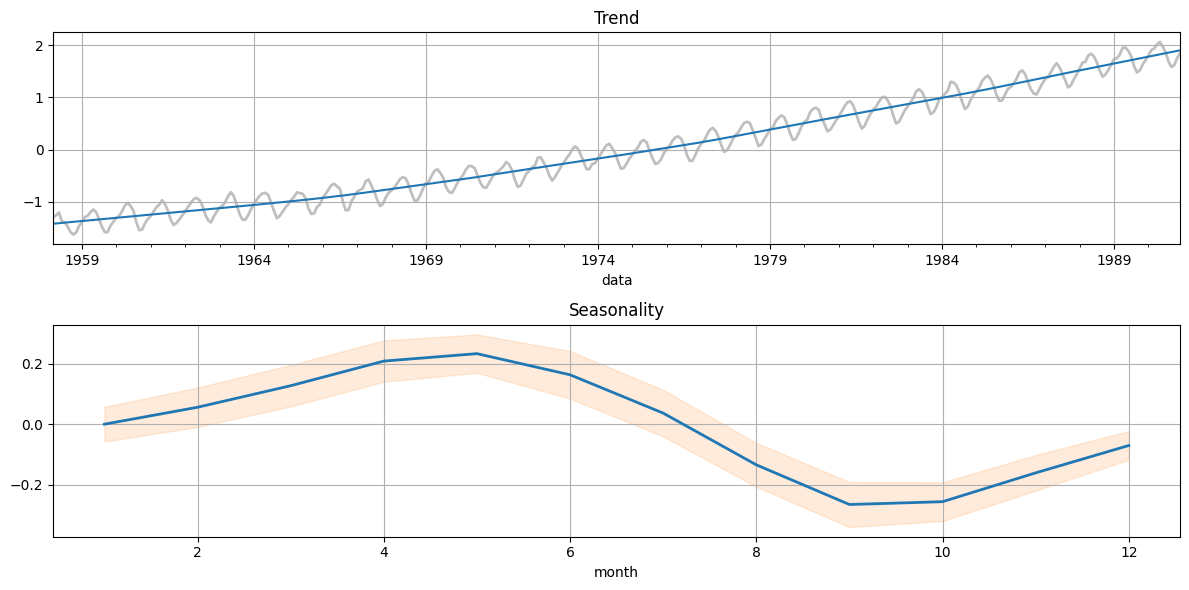

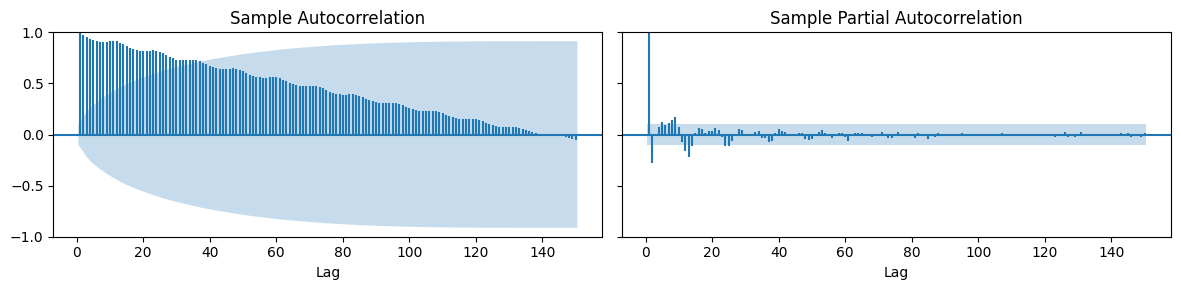

<ipython-input-30-afc5a90b209f>:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  "KPSS": kpss(series, regression="c")[:2],


{'ADF': (-1.8153609109557083, 0.6973047105179389),
 'KPSS': (3.346920389745789, 0.01)}

In [36]:
diagnostics(log_dataset[target_column], window=36)

The transformation did not give any special changes, but usually taking logarithms makes the estimation of the model parameters more stable.

Transform train sample in advance

In [37]:
train = transformer.fit_transform(dataset.values)

train = pd.DataFrame(train, index=dataset.index, columns=dataset.columns)

### C. Validation of the time series model (evaluation metrics)

We will evaluate the forecast accuracy using these metrics

$$
    MSE(y, \hat{y})
        = \tfrac1{m} \sum_{i=1}^m (y_i - \hat{y}_i)^2
\,. $$

In [38]:
from sklearn.metrics import mean_squared_error

$$
    RMSE(y, \hat{y}) = \sqrt{MSE(y, \hat{y})}
\,. $$

In [39]:
def root_mean_squared_error(*args, **kwargs):
    return np.sqrt(mean_squared_error(*args, **kwargs))

$$
    MAE(y, \hat{y})
        = \tfrac1{m} \sum_{i=1}^m \bigl\lvert y_i - \hat{y}_i \bigr\rvert
\,. $$

In [40]:
from sklearn.metrics import mean_absolute_error

$$
    \text{Median-AE}(y, \hat{y})
        = \text{median}\bigl\{
            \lvert y_1 - \hat{y}_1\rvert
            ,\, \ldots ,\,
            \lvert y_m - \hat{y}_m\rvert \bigr\}
\,. $$

In [41]:
from sklearn.metrics import median_absolute_error

$$
    MAPE(y, \hat{y})
        = \frac1{m} \sum_{i=1}^m
            \frac{\lvert y_i - \hat{y}_i \rvert}{\lvert y_i \rvert}
\,.$$

In [42]:
def mean_absolute_percent_error(y_true, y_pred):
    pct_error = abs(y_true - y_pred) / abs(y_true)
    return pct_error.mean(axis=0) * 100

$$
    R^2(y, \hat{y})
        = 1- \frac{\sum_{i=1}^m (y_i - \hat{y}_i)^2}{\sum_{i=1}^m (y_i - \bar{y})^2}
\,. $$

In [43]:
from sklearn.metrics import r2_score

$$
    \text{Explained Variance}(y, \hat{y})
        = 1 - \frac{\mathop{var}(y - \hat{y})}{\mathop{var}(y)}
\,. $$

In [44]:
from sklearn.metrics import explained_variance_score

List of all metrics

In [45]:
scorers = [
    ("mse", mean_squared_error),
]

# TODO: use more metrics!
#scorers = [
#    ("expl-var", TODO),
#    ("mse", TODO),
#    ("rmse", TODO),
#    ("mae", TODO),
#    ("median-ae", TODO),
#    ("r2", TODO),
#    ("mape", TODO)
#]

### Validation of the model of time series

Moving validation forward in time:

1. Sequential **leave-one-out**:

  - we train the model, predict one future observation, move for one observation forward

2. Sequential $ k $ - **fold**:

  - we split the sample into $ k $ consecutive blocks **without** mixing

  - we train the model, predict for the entire subsequent block, move for one block forward

Len of train sample during validation

- in training sample there is fixed number $w$ of observations $(x_s, y_s)_{s=t+1-w}^t$ -- *(rolling window)*

- in training sample there is whole backstory of observations  $(x_s, y_s)_{s \leq t}$ -- *(rolling prediction origin)*

#### $k$-fold with growing training sample

`Scikit-learn` has a built-in procedure for $ k $ -fold time series validation with **growing training sample**

<img src="https://habrastorage.org/r/w1560/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png" title="k-fold кроссвалидация временных рядов"
alt="https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection">

Materials: https://habr.com/ru/company/ods/blog/327242/

In [46]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=20, max_train_size=None)

Let's use handy functions from  `scikit` for indexing `pandas` matrix and coping of models

In [47]:
from sklearn.utils import _safe_indexing as safe_indexing

from sklearn.base import clone

## 4. Building an autoregressive model and a moving average

Autoregressive Integrated Moving Average (ARIMA) and Seasonal Autoregressive Integrated Moving Average (SARIMA), in the second model requires the choice of hyperparameters for both trend and seasonal elements of the series..



Read here: [seasonality in autoregressive models](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/)

In [48]:
from statsmodels.tsa.arima.model import ARIMA

* $ \phi (\cdot) $ and $ \theta (\cdot) $ - "lag polynomials" have no common roots

* $ \phi (\cdot) $ has no unit roots

* $ \varepsilon_t $ - white noise, i.e. has zero mean, constant variance, and zero autocorrelation.

The $ ARIMAX (p, d, q) $ process with exogenous variables has the form

\begin{align}
    y_t & = \overbrace {\mu + x_t \beta} ^ {\tau_t} + \delta_t
        \ ,, \\
    (1 - L) ^ d \, \delta_t & = u_t
        \ ,, \\
    \underbrace {\Bigl (1 - \sum_ {k = 1} ^ p \phi_k L ^ k \Bigr)} _ {\phi (L)}
        \, u_t & = \mu + \underbrace {\Bigl (1 + \sum_ {k = 1} ^ q \theta_k L ^ k \Bigr)} _ {\theta (L)}
        \, \varepsilon_t
        \ ,,
\end{align}

where $ L $ is the operator of shifting back one step into the past, i.e. $ L \, y_t = y_ {t-1} $

#### Evaluation Strategy for ARIMA Models (Box-Jenkins)

1. Check the fulfillment of the assumptions about stationarity, and find transformations that bring the series to stationarity

2. Diagnose autocorrelation to determine the order of lags in AR (`pacf`) and MA (` acf`) parts. Estimate the seasonality.

3. Among the reasonable combinations of orders, choose the one whose model has the smallest criterion **BIC** or **AIC**.

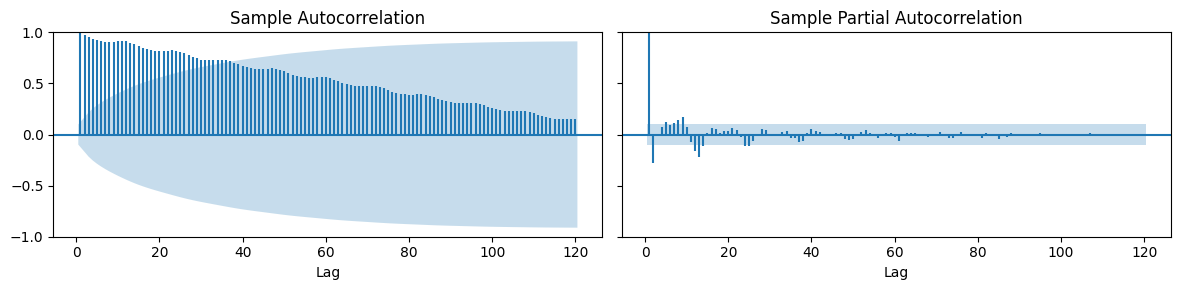

In [49]:
correlation_diagnostics(train, lags=120) ;

* autocorrelation of small lags is close to $1.0$ and decreases rather slowly
* there are suspicious fluctuations

There seems to be a unit root $ y_t = y_ {t-1} + \ldots $.

Train model ARIMA $(0, 1, 0)$

In [50]:
model_010 = ARIMA(train, order=(0, 1, 0))

model_010_fitted = model_010.fit()

Let's look at its residuals on the training set (and in differences)

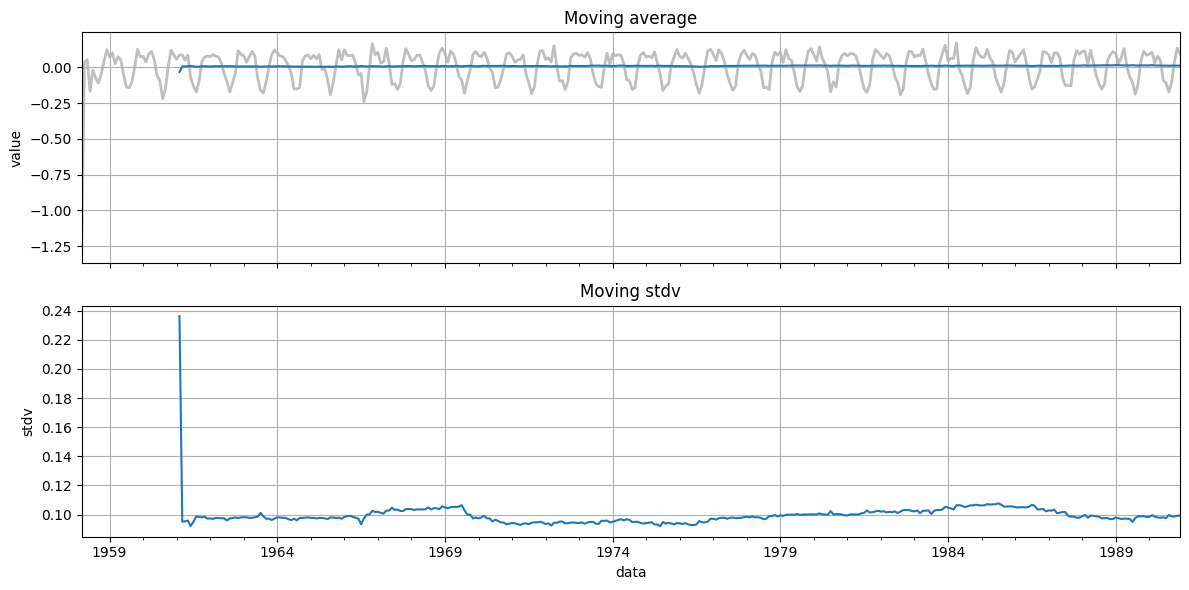

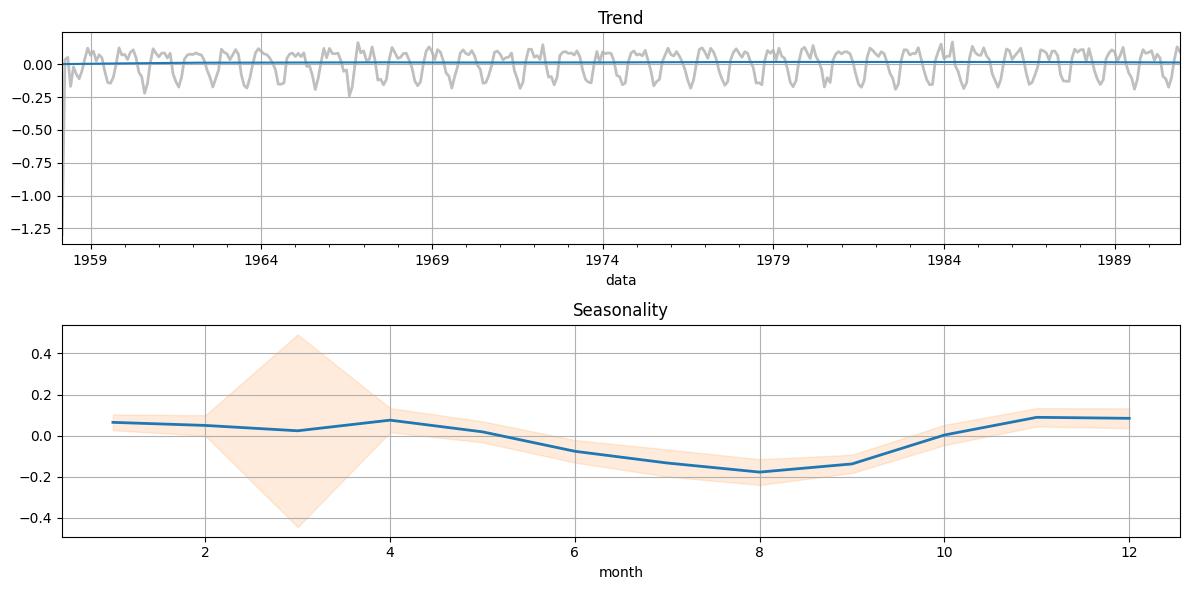

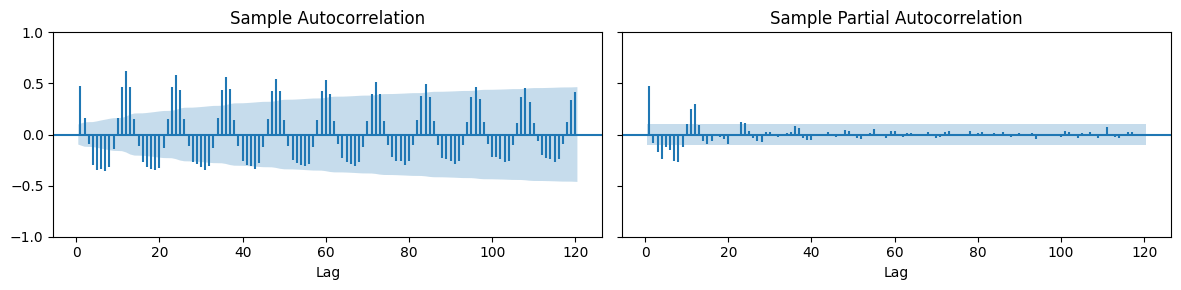

<ipython-input-30-afc5a90b209f>:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  "KPSS": kpss(series, regression="c")[:2],


{'ADF': (-5.500466976372381, 2.2996535420983782e-05),
 'KPSS': (0.1258717079769607, 0.1)}

In [51]:
diagnostics(model_010_fitted.resid, window=36, lags=120)

* A slow decrease in periodic ($ 12 $) bursts indicates a seasonal dependence of the form $ y_t = y_ {t-12} + \ldots $

The data seems to correlate with each other on a monthly basis, but also their level depends on the value of $ 12 $ months ago.

In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Process SARIMA$(p, d, q)\times (P, D, Q)_{s}$ has a form

\begin{align}
    (1 - L)^d \, (1 - L^s)^D \, y_t &= u_t
        \,, \\
    \Bigl(1 - \sum_{j=1}^p \phi_k L^j\Bigr)
        \, \Bigl(1 - \sum_{j=1}^P \tilde{\phi}_k L^{s j}\Bigr)
        \, u_t &= \mu \, +
        \, \Bigl(1 + \sum_{j=1}^q \theta_k L^j\Bigr)
        \, \Bigl(1 + \sum_{j=1}^Q \tilde{\theta}_k L^{s j}\Bigr)
        \, \varepsilon_t
        \,.
\end{align}

Let's look at its residuals on the training set for different orders of models

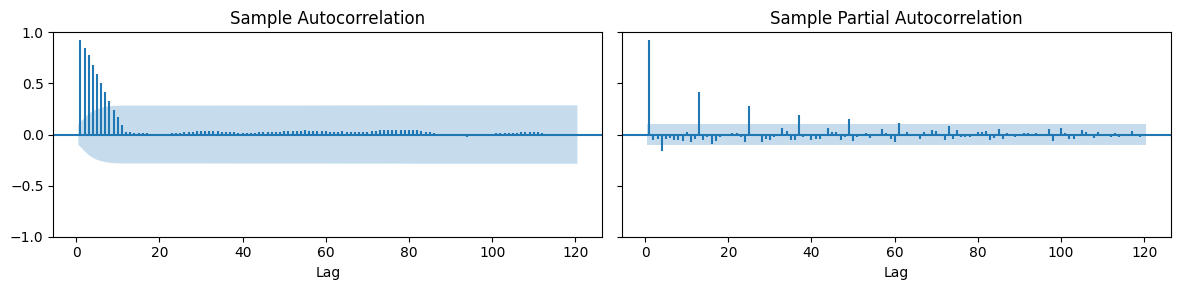

In [53]:
model_sarima_000_010_12 = SARIMAX(train, order=(0, 0, 0), seasonal_order=(0, 1, 0, 12),
                                  enforce_stationarity=False, enforce_invertibility=False)

model_sarima_000_010_12_fitted = model_sarima_000_010_12.fit(disp=0)

correlation_diagnostics(model_sarima_000_010_12_fitted.resid, lags=120) ;

* When taking the difference $ y_t - y_ {t-12} $, it seems that there are traces of the usual unit root

Let's examine the model
$$
    (1 - L^{12})(1 - L) y_t
        = \bigl[y_{t} - y_{t-1} - y_{t-12} + y_{t-13}\bigr]
        = \mu + \varepsilon_t
    \,,$$

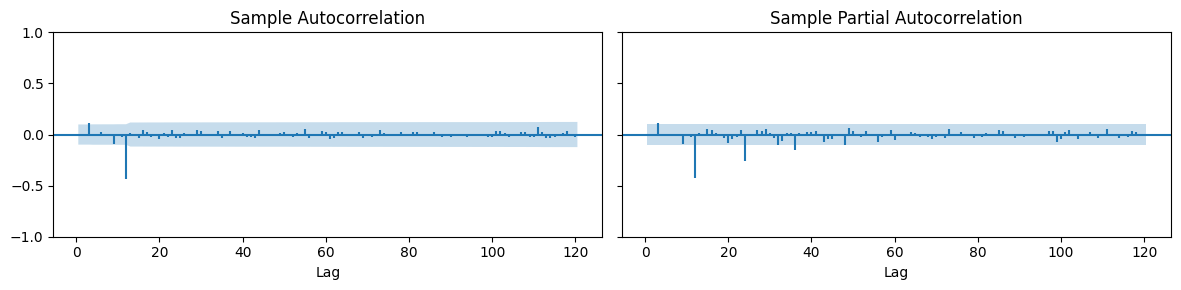

In [54]:
model_sarima_010_010_12 = SARIMAX(train, order=(0, 1, 0), seasonal_order=(0, 1, 0, 12),

                                  enforce_stationarity=False, enforce_invertibility=False)

model_sarima_010_010_12_fitted = model_sarima_010_010_12.fit(disp=0)

correlation_diagnostics(model_sarima_010_010_12_fitted.resid, lags=120) ;

Chose model with the lowest value of **BIC** (Bayesian information criterion)

Read here: [BIC](http://www.machinelearning.ru/wiki/index.php?title=%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D0%B8%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D0%B9_%D0%BA%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9)

In [55]:
models = [
  model_010_fitted,
  model_sarima_000_010_12_fitted,
  model_sarima_010_010_12_fitted,
]

[getattr(mdl, "bic") for mdl in models]

[-704.9524542637402, -559.8258662874105, -1440.9079798385194]

In [56]:
sarima_fitted = models[-1]

The `SARIMAX` object returns the fitted values ​​on the training sample in the` fittedvalues` property:
* the row matches the prediction in the original data values ​​(** NOT ** in the differences, like `ARIMA`)

In [57]:
if isinstance(sarima_fitted.model, SARIMAX):
    series_fitted = sarima_fitted.fittedvalues.to_frame()

elif isinstance(sarima_fitted.model, ARIMA):
    series_fitted = np.concat([
        train.iloc[:1],             # adding a little bit of backstory (for integral)
        sarima_fitted.fittedvalues,  # fitted values added
    ], axis=0).cumsum(axis=0)

Inverse transformation

In [58]:
series_fitted = transformer.inverse_transform(series_fitted)

fitted_arima = pd.Series(series_fitted.ravel(),
                         name=target_column,
                         index=dataset.index)

Let's look on plot of fitting

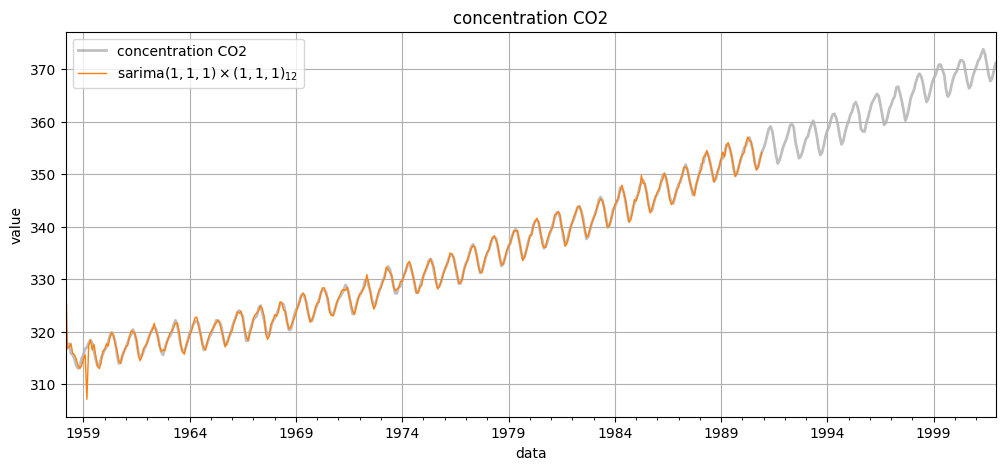

In [59]:
# create and set a plit
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Data", ylabel="value", title=target_column)

# plot dynamic of series
full_dataset[target_column].plot(ax=ax, color="black",
                                 lw=2, alpha=0.25, zorder=-10)

fitted_arima.plot(ax=ax, color="C1", lw=1, alpha=1.0,
                  label="sarima$(1,1,1)\\times(1,1,1)_{12}$")

ax.grid(which="major", axis="both")
ax.legend() ;


Let's look at the **dynamic** forecast for $ 240 $ months ahead

In [60]:
# Forecast for 240 month forward
sarima_forecast = sarima_fitted.forecast(steps=240).to_frame()

sarima_forecast = pd.DataFrame(transformer.inverse_transform(sarima_forecast),
                            columns=sarima_forecast.columns,
                            index=sarima_forecast.index)

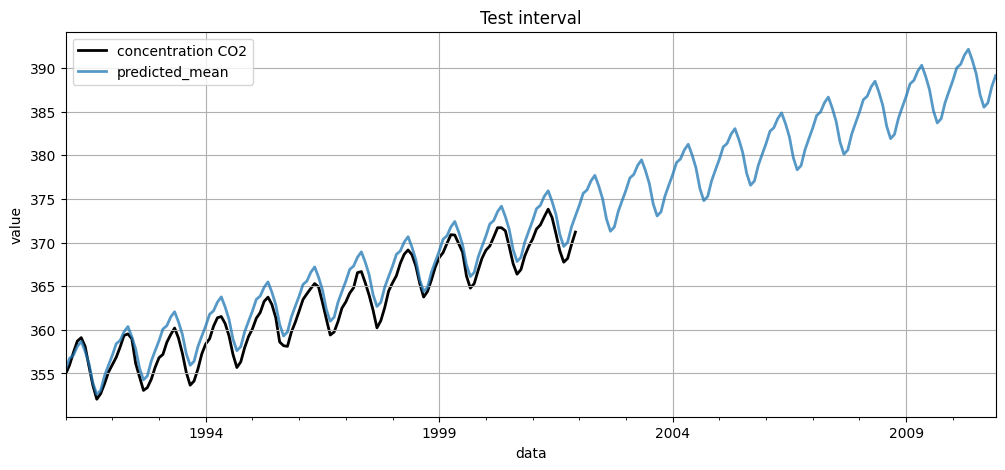

In [61]:
# create and set plot
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Data", ylabel="value", title="Test interval")

# plot dynamic
holdout[target_column].plot(ax=ax, color="black", lw=2, alpha=1., zorder=-10)

sarima_forecast.plot(ax=ax, color="C0", lw=2, alpha=0.75, label="dynamic forecast sarima")

ax.grid(which="major", axis="both")
ax.legend() ;

Count metrics

In [62]:
holdout_sarima_score_values = pd.Series({
    name: metric(holdout[target_column],
                 sarima_forecast.iloc[:len(holdout), 0])
    for name, metric in scorers
})

In [63]:
holdout_sarima_score_values

mse    2.936343
dtype: float64

Validation of model

In [64]:
raw_forecast = np.full_like(dataset, np.nan)
for train_ix, test_ix in tqdm(tscv.split(train)):
    # split on train and test
    cv_train = safe_indexing(dataset, train_ix)

    # 1. "forward transformation" of series
    cv_transformer = clone(transformer).fit(cv_train)
    cv_train = pd.DataFrame(cv_transformer.transform(cv_train),
                            index=cv_train.index, columns=cv_train.columns)

    # 2. model estimation
    cv_model = SARIMAX(cv_train[target_column],
                       order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

    try:
        cv_model_fitted = cv_model.fit(disp=0)
    except ValueError:
        continue

    # 3. building forecast
    cv_test = safe_indexing(dataset, test_ix)
    cv_forecast = cv_model_fitted.forecast(len(cv_test)).to_frame()

    # 4. "inverse transformation" of raw
    raw_forecast[test_ix] = cv_transformer.inverse_transform(cv_forecast)

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
1it [00:00,  1.18it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_function_transformer.py:310: RuntimeWarning: overflow encountered in exp
  return func(X, **(kw_args if kw_args else {}))
3it [00:04,  1.35s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
8it [00:09,  1.10s

Unfortunately, due to the modesty of the sample size, sometimes SARIMA is estimated inadequately (on series with a short history).

In [65]:
raw_forecast[np.nan_to_num(raw_forecast) <= 0] = np.nan

raw_forecast[~np.isfinite(raw_forecast)] = np.nan

tscv_sarima_forecast = pd.DataFrame(raw_forecast, index=dataset.index, columns=dataset.columns)

Collecting forecasts in series and plotting

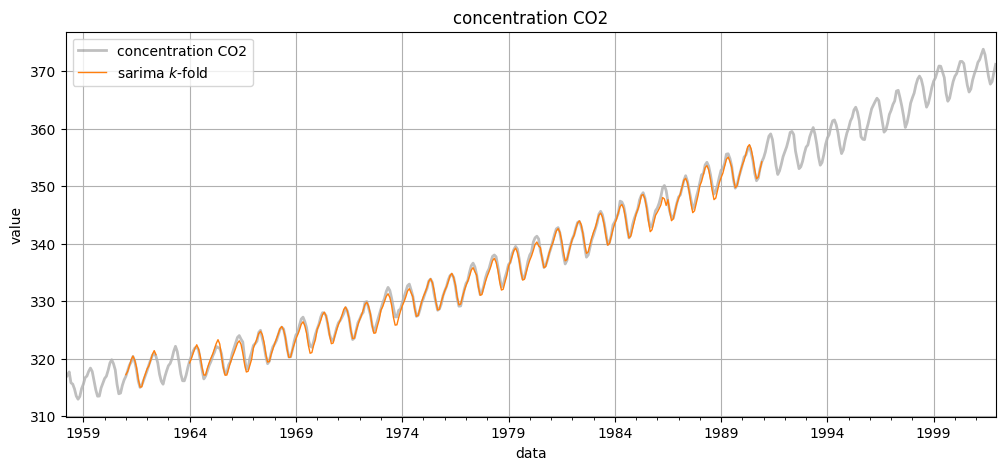

In [66]:
# create and set plot
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Data", ylabel="value", title=target_column)

# plot dynamic of series and forecasts
full_dataset[target_column].plot(ax=ax, color="black",
                                 lw=2, alpha=0.25, zorder=-10)

tscv_sarima_forecast[target_column].plot(ax=ax, color="C1", lw=1, alpha=1.0,
                                         label="sarima $k$-fold")

ax.grid(which="major", axis="both")
ax.legend() ;


Counting metric on "test intervals"

In [67]:
has_forecast = tscv_sarima_forecast.isnull().any(axis=1)

In [68]:
has_forecast = tscv_sarima_forecast.isnull().any(axis=1)
metrics_dict = {name: metric(dataset.loc[~has_forecast], tscv_sarima_forecast.loc[~has_forecast]) for name, metric in scorers}

In [69]:
metrics_dict

{'mse': 0.3572217900040775}